<a href="https://colab.research.google.com/github/underham2ter/bio-minor/blob/main/HW7/bioinf_hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для выполнения задания была выбрана 1B хромосома организма *Ochotona princeps (American pika)*.

- Страница сборки на сайте ncbi: 

 [www.ncbi.nlm.nih.gov/assembly/GCF_014633375.1](https://www.ncbi.nlm.nih.gov/assembly/GCF_014633375.1/#/def)  → sequence.fasta

-  Также нам понадобится разметка генома. Ее возьмем из инструмента Genome Data Viewer на том же сайте: 
 
 [www.ncbi.nlm.nih.gov/genome/gdv/browser/genome/?id=GCF_014633375.1](https://www.ncbi.nlm.nih.gov/genome/gdv/browser/genome/?id=GCF_014633375.1)  → Genes.csv


- Смешное видео на ютубе от BBC Earth с участием организма: 

 [How the Collared Pika Prepares For Winter](https://www.youtube.com/watch?v=F8edS07_Cys)
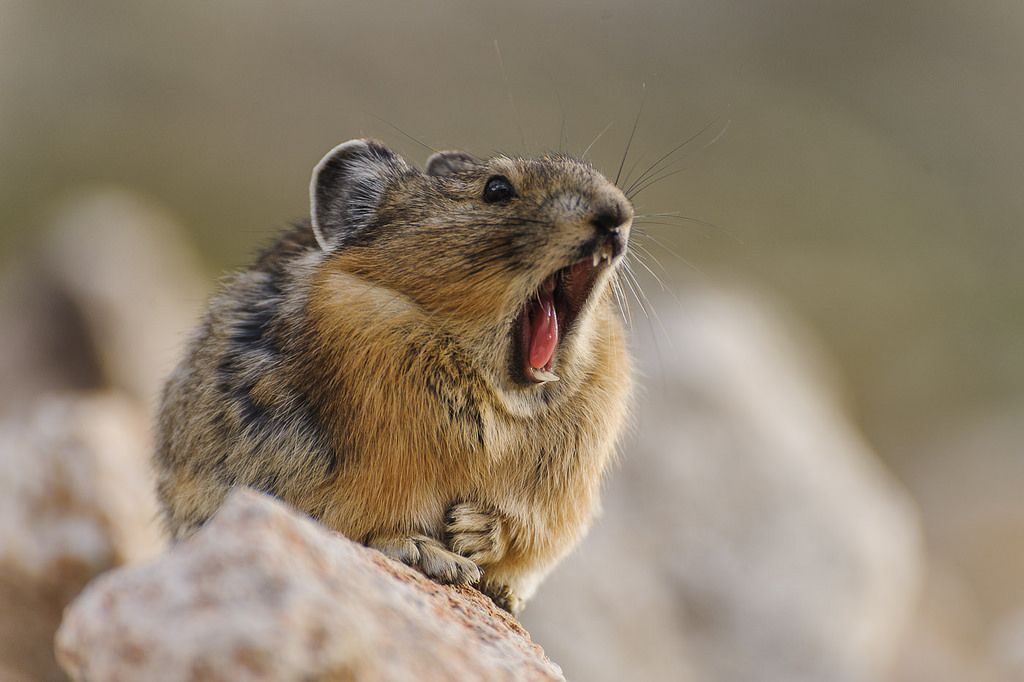

# **1.** Запускаем zhunt3 и даем ему на вход нашу хромосому:

In [ ]:
!gcc zhunt3-alan.c -lm -o zhunt3

In [ ]:
!chmod a+x zhunt3
!./zhunt3 12 8 12 sequence.fasta

In [5]:
import pandas as pd
z=pd.read_csv("sequence.fasta.Z-SCORE",
              skiprows=1, 
              names=["Start","End","-","-","-","Score","Seq","-"],
              delim_whitespace=True)

# Далее отсеиваем вхождения со скором меньше **500** и получаем **32914** вхождений (при этом есть пересечения между возможными участками Z-DNA).

In [7]:
z.loc[z['Score'] >= 500]

,Start,End,1,2,3,Score,Seq,4
1402,1403,1427,24,21.499,46.581,736.1451,tgggactctgcgcccacgtgggtg,ASSASAASASASASASASASASAS
1404,1405,1427,22,21.334,45.135,900.2643,ggactctgcgcccacgtgggtg,SASAASASASASASASASASAS
1406,1407,1427,20,21.181,49.427,1087.2500,actctgcgcccacgtgggtg,SAASASASASASASASASAS
1408,1409,1427,18,20.989,50.094,1383.8140,tctgcgcccacgtgggtg,ASASASASASASASASAS
1409,1410,1426,16,21.688,47.164,587.6539,ctgcgcccacgtgggt,SASASASASASASASA
...,...,...,...,...,...,...,...,...
11417718,11417719,11417735,16,20.558,53.915,2422.7760,acacacacacacacac,SASASASASASASASA
11417719,11417720,11417736,16,20.558,52.034,2422.7760,cacacacacacacaca,ASASASASASASASAS
11417720,11417721,11417737,16,21.046,49.482,1287.7860,acacacacacacacat,SASASASASASASASA
11417721,11417722,11417738,16,21.210,47.707,1049.1170,cacacacacacacatt,ASASASASASASASAS


# **2.** Для поиска квадруплексов воспользуемся регуляркой с семинара и получим **783** вхождения (без пересечений):

In [ ]:

!pip install biopython
import re
from Bio import SeqIO

In [80]:
records = list(SeqIO.parse("sequence.fasta", "fasta"))
record = records[0]

name, sequence = record.id, str(record.seq)

pattern="(?:G{3,}[ATGC]{1,7}){3,}G{3,}"

quad_data=[[m.start(),m.end(),m.group(0)] for m in re.finditer(pattern,sequence)]

quad_data[:5] # start stop seq

[[13238, 13261, 'GGGCTGGGGGTGACGTGGGGGGG'],
 [21246, 21274, 'GGGGGGAGGGCGGGGGGGAGGGGTGGGG'],
 [27870, 27896, 'GGGGAGCTGGGTAGGGGATACTTGGG'],
 [77386, 77408, 'GGGAGGGAGTGGGATGATGGGG'],
 [80591, 80610, 'GGGAATGGGGTGGGCAGGG']]

In [79]:
len(quad_data)

783

# **3,4,5** Воспользуемся простым скриптом ниже, чтобы понять куда попадают Z-ДНК и квадруплексы: в гены, в участки между ними или на пересечении:

In [32]:
# Загрузка файла с разметкой генома
genome_data = pd.read_csv('Genes.CSV',
                          skiprows=2, 
                          names=["Accession","Start",
                                 "Stop","Gene symbol",
                                 "Strand","NCBI Gene ID",
                                 "Name"]
                          )

z_dna_data = z.loc[z['Score'] >= 500]

z_dna_data.Start.head()
# genome_data.head()

,Accession,Start,Stop,Gene symbol,Strand,NCBI Gene ID,Name
0,NC_050559.1,69551,70389,FAM122A,plus,101529385,NaN
1,NC_050559.1,103118,204827,PIP5K1B,plus,101527580,NaN
2,NC_050559.1,213024,226194,FXN,plus,101527826,NaN
3,NC_050559.1,298260,369345,TJP2,plus,101528076,NaN
4,NC_050559.1,369935,423934,FAM189A2,plus,101528334,NaN


In [89]:

z_in_gene = 0 # Кол-во в гене
z_on_inter = 0 # Кол-во пересечений

names = {}

# Функция для определения попадания координаты в ген или межгенное пространство
def find_overlap(start, stop, gene_start, gene_stop, strand, name):
    global z_in_gene
    global z_on_inter
    global names
    

    if strand == 'plus':
            promoter_start = gene_start - 1000
            promoter_stop = gene_start
    else:
            promoter_start = gene_start
            promoter_stop = gene_start + 1000

    if start >= promoter_start and stop <= promoter_stop:
          if name not in names:
            names[name] = 1
          else:
            names[name] += 1
    # В гене?
    if start >= gene_start and stop <= gene_stop:
        z_in_gene += 1
    # На перечесении?
    elif (start < gene_start and stop > gene_start) or (start < gene_stop and stop > gene_stop):
        z_on_inter += 1


# Перебор каждой записи в разметке Z-ДНК
for _, z_dna_row in z_dna_data.iterrows():
    z_dna_start = z_dna_row.Start
    z_dna_stop = z_dna_row.End

    # Перебор каждой записи в разметке генома
    for _, genome_row in genome_data.iterrows():
        gene_start = int(genome_row.Start)
        gene_stop = int(genome_row.Stop)
        gene_symbol = genome_row['Gene symbol']
        strand = genome_row['Strand']

        # Проверка попадания координаты в ген
        find_overlap(z_dna_start, z_dna_stop, gene_start, gene_stop, strand, gene_symbol)

z_outside = len(z_dna_data) - z_on_inter - z_in_gene


# Список названий генов, в промоторы которых попадает Z-ДНК:

In [99]:
sorted_names = sorted(names.items(), key=lambda x: -x[1])
sorted_names

[('GLIS3', 138),
 ('KIAA2026', 61),
 ('FANCC', 41),
 ('FAM189A2', 36),
 ('ZNF367', 36),
 ('PRXL2C', 33),
 ('SPATA6L', 33),
 ('TRPM6', 26),
 ('MAMDC2', 25),
 ('LOC101536196', 24),
 ('RANBP6', 22),
 ('LOC118760000', 21),
 ('PSAT1', 21),
 ('PTCH1', 20),
 ('CEP78', 19),
 ('SLC1A1', 15),
 ('CDC14B', 14),
 ('FOXB2', 13),
 ('PCSK5', 11),
 ('TLE4', 10),
 ('SMC5', 9),
 ('PLGRKT', 9),
 ('TMC1', 7),
 ('AK3', 7),
 ('SLC35D2', 6),
 ('INSL6', 5),
 ('LOC101533430', 4),
 ('FAM122A', 3),
 ('RORB', 2),
 ('GDA', 1),
 ('LOC101531525', 1),
 ('LOC101516767', 1),
 ('LOC118759994', 1)]

In [100]:
for item in sorted_names:
  print(item[0])

GLIS3
KIAA2026
FANCC
FAM189A2
ZNF367
PRXL2C
SPATA6L
TRPM6
MAMDC2
LOC101536196
RANBP6
LOC118760000
PSAT1
PTCH1
CEP78
SLC1A1
CDC14B
FOXB2
PCSK5
TLE4
SMC5
PLGRKT
TMC1
AK3
SLC35D2
INSL6
LOC101533430
FAM122A
RORB
GDA
LOC101531525
LOC101516767
LOC118759994


# Примерно половина отказалась внутри генов (**16265, 49.4%**) и половина снаружи (**16583, 50%**). Незначительное число оказалось на пересечении.

In [90]:
z_in_gene, z_on_inter, z_outside

(16265, 66, 16583)

In [87]:

quads_in_gene = 0
quads_on_inter = 0
quad_names = {}

# Функция для определения попадания координаты в ген
def find_overlap_quad(start, stop, gene_start, gene_stop, strand, name):
    global quads_in_gene
    global quads_on_inter
    global quad_names

    if strand == 'plus':
            promoter_start = gene_start - 1000
            promoter_stop = gene_start
    else:
            promoter_start = gene_start
            promoter_stop = gene_start + 1000

    if start >= promoter_start and stop <= promoter_stop:
          if name not in quad_names:
            quad_names[name] = 1
          else:
            quad_names[name] += 1

    # В гене?
    if start >= gene_start and stop <= gene_stop:
        quads_in_gene += 1
    # На перечесении?
    elif (start < gene_start and stop > gene_start) or (start < gene_stop and stop > gene_stop):
        quads_on_inter += 1




# Перебор каждой записи в разметке Z-ДНК
for quad_dna_start, quad_dna_stop, _ in quad_data:
    # Перебор каждой записи в разметке генома
    for _, genome_row in genome_data.iterrows():
        gene_start = int(genome_row.Start)
        gene_stop = int(genome_row.Stop)
        gene_symbol = genome_row['Gene symbol']
        strand = genome_row['Strand']

        # Проверка попадания координаты в ген, межгенное пространство или пересечение
        find_overlap_quad(quad_dna_start, quad_dna_stop, gene_start, gene_stop, strand, gene_symbol)

quads_outside = len(quad_data) - quads_on_inter - quads_in_gene

# Список названий генов, в промоторы которых попадают квадруплексы:

In [75]:
sorted(quad_names.items(), key=lambda x: -x[1])

[('KIAA2026', 3),
 ('CEP78', 2),
 ('SPATA6L', 2),
 ('APBA1', 1),
 ('ABHD17B', 1),
 ('C1BH9orf85', 1),
 ('PCSK5', 1),
 ('VPS13A', 1),
 ('LOC101517012', 1),
 ('CDC14B', 1),
 ('HSD17B3', 1),
 ('AOPEP', 1),
 ('ERMP1', 1),
 ('SMARCA2', 1),
 ('DMRT3', 1)]

In [98]:
for key in quad_names.keys():
  print(key)

APBA1
ABHD17B
C1BH9orf85
PCSK5
VPS13A
LOC101517012
CEP78
CDC14B
HSD17B3
AOPEP
KIAA2026
ERMP1
SPATA6L
SMARCA2
DMRT3


# Расположение квадруплексов схоже с Z-ДНК. Внутри **51.9%** попаданий, снаружи - **48%**. Незначительное число оказалось на пересечении.

In [88]:
quads_in_gene, quads_on_inter, quads_outside

(406, 2, 375)

# **6** . Результаты Gene Enrichment Analysis
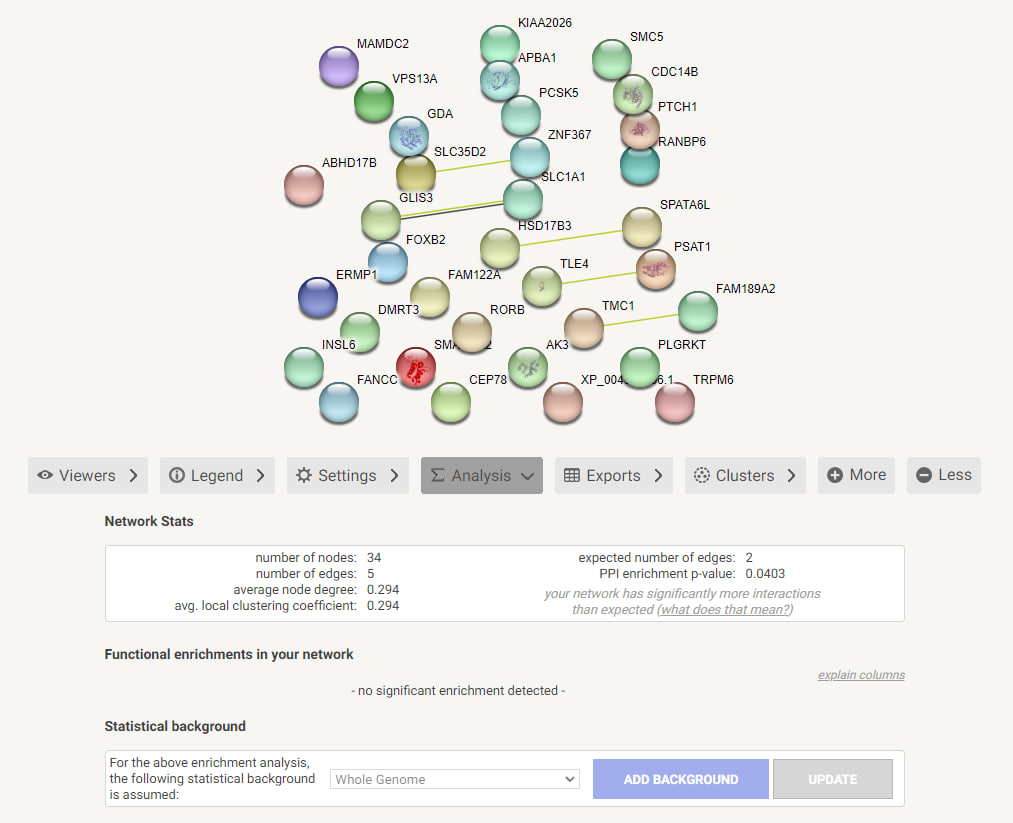

no significant enrichment detected :(